In [54]:
suppressMessages({
    library(Seurat)
    library(tidyverse)
    library(future)
})

In [4]:
data_dir <- '/PROJ/k8s/PROJ/nas-ddcf33da-5d64-4f22-bbd7-357afb41ec0b/SG210319-TS01/SG210319-TS01-20210611/countBarcodeYaml/XC210301G_10ZLH_PL/filtered_feature_bc_matrix'
counts <- Read10X(data.dir = data_dir)
obj <- CreateSeuratObject(counts=counts)
obj[['percent.mito']] <- PercentageFeatureSet(object = obj, pattern = '^(MT|mt|Mt)-')

In [51]:
id_map <- read_delim(paste0(data_dir ,'/features.tsv.gz'), delim="\t",
                        col_names = c('Ensembl', 'Symbol', 'Type')) %>% dplyr::select(-Type) %>%
          mutate(Symbol_uniq=make.unique(Symbol))



── Column specification ────────────────────────────────────────────────────────
cols(
  Ensembl = col_character(),
  Symbol = col_character(),
  Type = col_character()
)




In [20]:
obj[[]] %>% summarise( probs=seq(0, 1, 0.1), quantile=quantile(percent.mito, seq(0, 1, 0.1))) %>% mutate(probs=sprintf('%s%%', probs*100))

probs,quantile
<chr>,<dbl>
0%,0.000000
10%,6.165919
20%,7.692308
30%,8.907223
40%,10.166359
50%,11.777853
60%,13.686968
70%,15.473067
80%,17.008197


In [22]:
obj[[]] %>% summarise( probs=seq(0, 1, 0.1), quantile=quantile(nFeature_RNA, seq(0, 1, 0.1))) %>% mutate(probs=sprintf('%s%%', probs*100))

probs,quantile
<chr>,<dbl>
0%,207.0
10%,399.0
20%,454.0
30%,527.0
40%,669.0
50%,874.5
60%,1114.0
70%,1435.5
80%,1822.0


In [23]:
obj[[]] %>% summarise( probs=seq(0, 1, 0.1), quantile=quantile(nCount_RNA, seq(0, 1, 0.1))) %>% mutate(probs=sprintf('%s%%', probs*100))

probs,quantile
<chr>,<dbl>
0%,500.0
10%,580.0
20%,677.0
30%,817.0
40%,1105.0
50%,1616.5
60%,2380.0
70%,3469.5
80%,4813.0


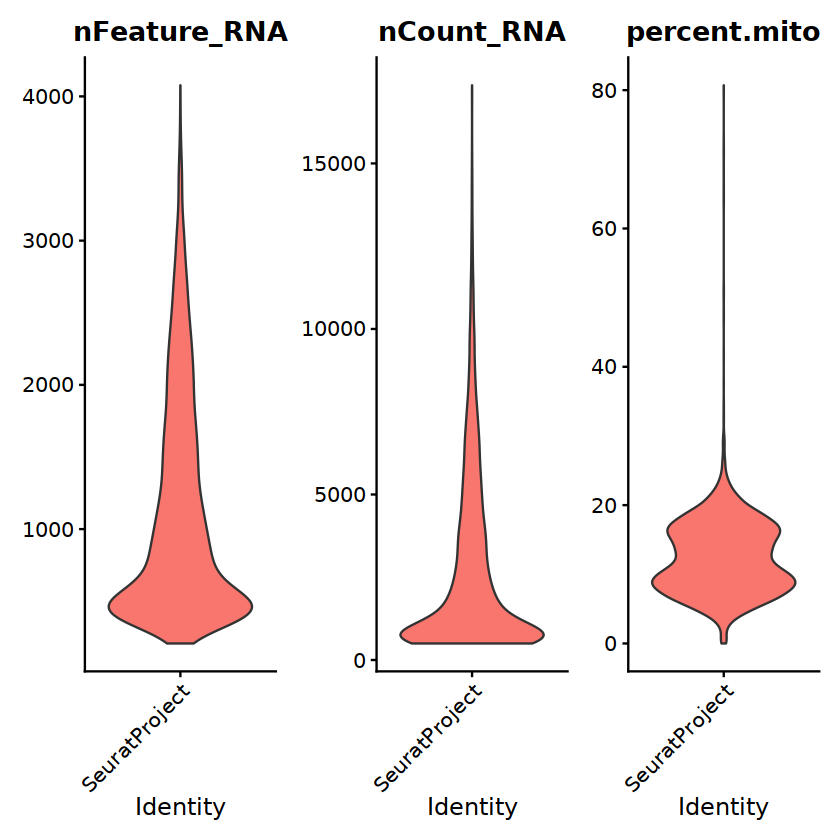

In [24]:
VlnPlot(obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"), ncol = 3, pt.size=0) 

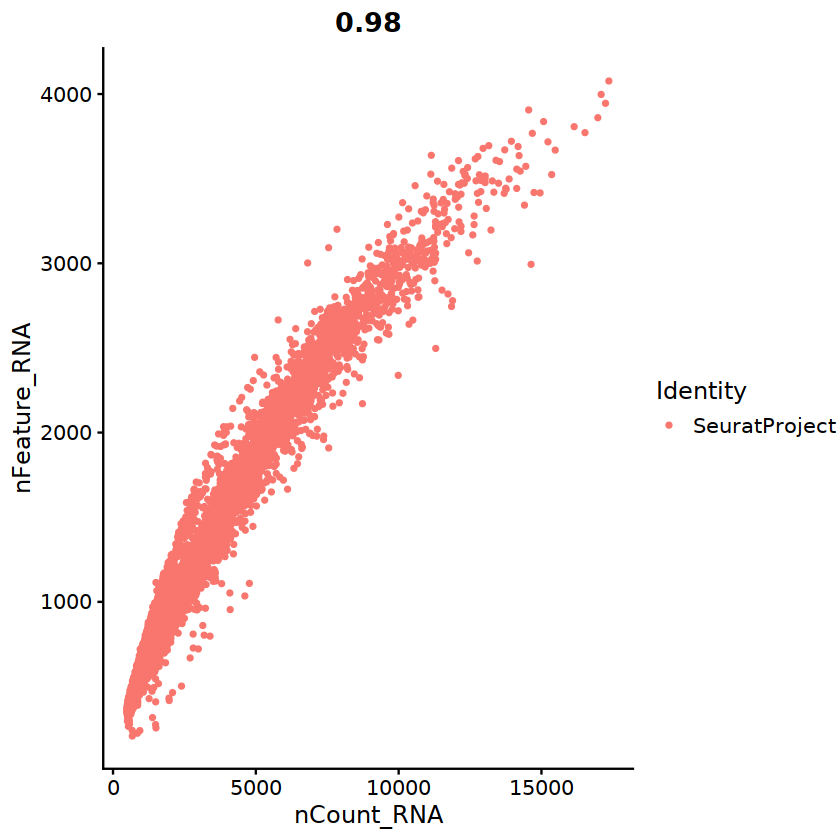

In [40]:
FeatureScatter(obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

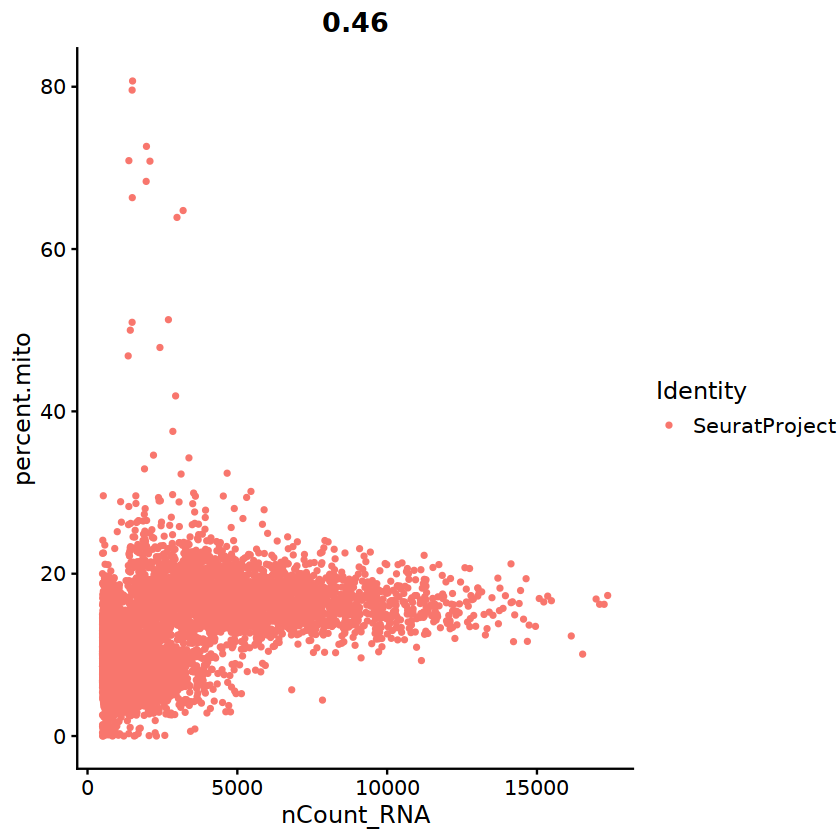

In [41]:
FeatureScatter(obj, feature1 = "nCount_RNA", feature2 = "percent.mito")

In [28]:
obj <- NormalizeData(obj, verbose = FALSE)
obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
obj <- ScaleData(obj, verbose = FALSE)
obj <- RunPCA(obj, npcs = 30, verbose = FALSE)

In [36]:
obj <- JackStraw(obj, num.replicate = 100, dims=30)

Warning message:
“Removed 43242 rows containing missing values (geom_point).”


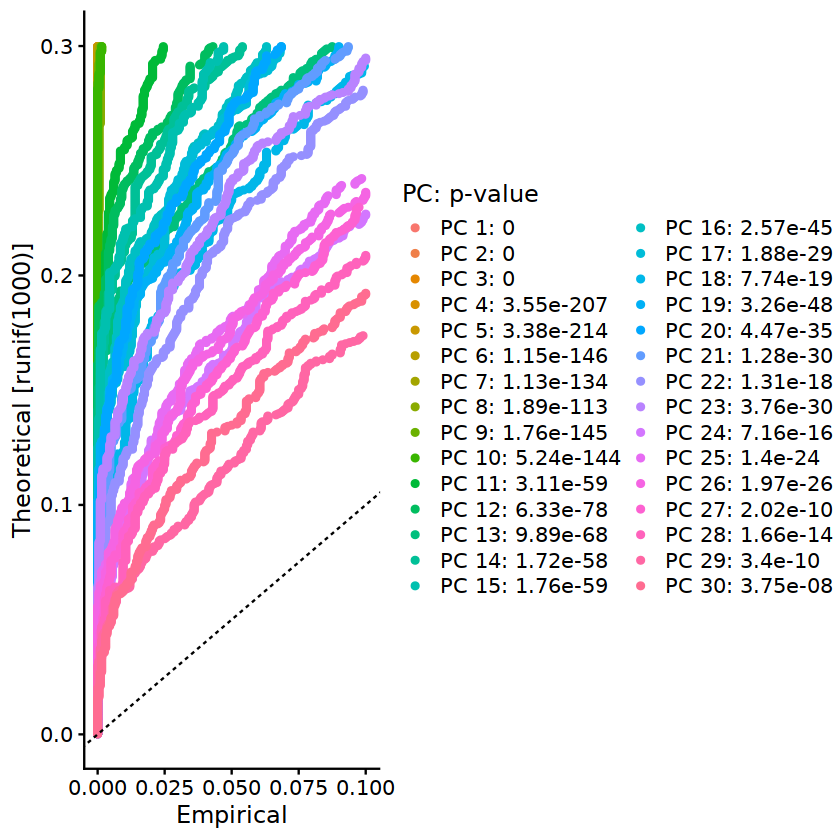

In [37]:
obj <- ScoreJackStraw(obj, dims = 1:30)
JackStrawPlot(obj, dims = 1:30)

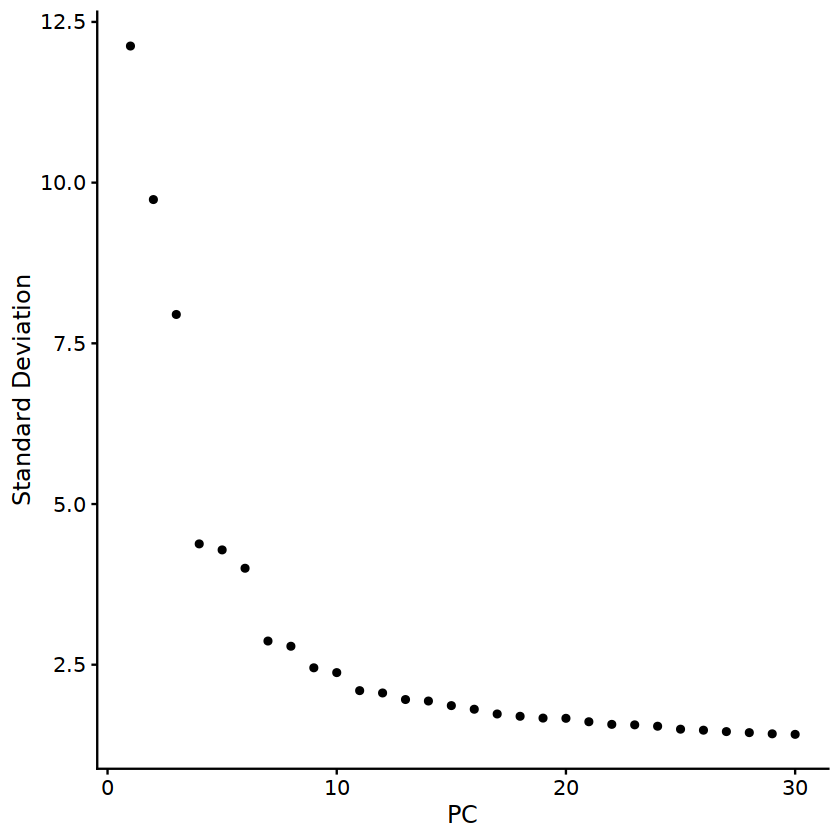

In [39]:
ElbowPlot(obj, ndims = 30)

In [42]:
obj <- FindNeighbors(obj, dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [43]:
obj <- FindClusters(obj, resolution = 0.8)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7766
Number of edges: 302097

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8834
Number of communities: 15
Elapsed time: 0 seconds


In [47]:
obj <- RunUMAP(obj, reduction = "pca", dims = 1:30, verbose = FALSE)

In [49]:
obj <- RunTSNE(obj, reduction = "pca", dims = 1:30, check_duplicates = FALSE)

In [ ]:
umap_loci <- cbind(as.data.frame(Embeddings(obj, reduction='umap')), obj[[]])

In [ ]:
tsne_loci <- cbind(as.data.frame(Embeddings(obj, reduction='tsne')), obj[[]])

In [52]:
# plan()
obj.markers <- FindAllMarkers(obj, logfc.threshold=0.25, min.pct=0.1) %>%
                    left_join(id_map, by=c('gene'='Symbol_uniq')) %>%
                    dplyr::select(-Symbol) %>% dplyr::relocate(gene, Ensembl)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [55]:
dim(obj.markers)

[1] 20181     8